### Loading in some Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries
from sklearn.metrics import accuracy_score

from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function

from tensorflow.keras.models import load_model
from counterfactual_utils import ucr_data_loader, label_encoder
print(tf.__version__)

TF version:  2.4.1
Eager execution enabled:  False
2.4.1


In [2]:
np.random.seed(0)
#setting a random seed

### Loading data and classifier example

In [3]:
X_train, y_train, X_test, y_test = ucr_data_loader(str('cbf'))
y_train, y_test = label_encoder(y_train, y_test)
model =load_model('cbf_best_model.hdf5')
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [4]:
accuracy_score(y_test,y_pred)

0.9955555555555555

### Next we want to be able to specify what our counterfactual target is. This should be different to the predicted label of the base classifier. Also lets specify the loss function

In [5]:
def target_(instance):
    #Let's Make CF class the second most probable class according to original prediction
    target = np.argsort((model.predict(instance.reshape(1,-1,1))))[0][-2:-1][0] 
    return target

def dist_mad(query, cf):
    manhat = np.abs(query-cf)
    mad = stats.median_absolute_deviation(X_train)
    return np.sum((manhat/mad).flatten())

def loss_function_mad(x_dash):
    target = target_(to_be_explained_instance)
    L = lamda*(model.predict(x_dash.reshape(1,-1,1))[0][target] - 1)**2 + \
    dist_mad(x_dash.reshape(1,-1,1), query)
    return L

### Wachter Counterfactuals

In [6]:
def Wachter_Counterfactual(instance, lambda_init):
    
    min_edit_cf = []
    undefined_cf_instance = []
    global lamda
    global dist_mad
    global loss_function_mad
    global to_be_explained_instance
    global query

    
    pred_threshold = 0.5

    # initial conditions
    lamda = lambda_init
    x0 = X_test[instance].reshape(1,-1,1) # initial guess for cf
    query = X_test[instance].reshape(1,-1,1)

    to_be_explained_instance = X_test[instance]
    #eoins edit

    res = minimize(loss_function_mad, x0.reshape(1,-1), method='nelder-mead', options={'maxiter':10, 'xatol': 50, 'adaptive': True})
    cf = res.x.reshape(1,-1,1)

    target = target_(X_test[instance])
    prob_target = model.predict(cf)[0][target]


    i=0
    while prob_target < pred_threshold:


        lamda = lambda_init*(1+0.5)**i
        x0 = cf # starting point is current cf. In our case we use the native-guide or nun
        res = minimize(loss_function_mad, x0.reshape(1,-1), method='nelder-mead', options={'maxiter':10, 'xatol': 50, 'adaptive': True})
        cf = res.x.reshape(1,-1,1)
        prob_target = model.predict(cf)[0][target]
        i += 1
        if i == 500:
            print('Error condition not met after',i,'iterations')
            print(str(instance))
            undefined_cf_instance.append(instance)
            break

    min_edit_cf.append(cf[0])

    
    return min_edit_cf, undefined_cf_instance

### Implementation (checking if each point generates a cf)

In [11]:
min_edit_cf = []
undefined_cf_instance = []

for instance in range(len(X_test)):
    
    global lamda
    global dist_mad
    global loss_function_mad
    global to_be_explained_instance
    global query

    
    pred_threshold = 0.5

    # initial conditions
    lambda_init = 0.1
    lamda = lambda_init
    x0 = X_test[instance].reshape(1,-1,1) # initial guess for cf
    query = X_test[instance].reshape(1,-1,1)

    to_be_explained_instance = X_test[instance]
    #eoins edit

    res = minimize(loss_function_mad, x0.reshape(1,-1), method='nelder-mead', options={'maxiter':10, 'xatol': 50, 'adaptive': True})
    cf = res.x.reshape(1,-1,1)

    target = target_(X_test[instance])
    prob_target = model.predict(cf)[0][target]


    i=0
    while prob_target < pred_threshold:


        lamda = lambda_init*(1+0.5)**i
        x0 = cf # starting point is current cf. In our case we use the native-guide or nun
        res = minimize(loss_function_mad, x0.reshape(1,-1), method='nelder-mead', options={'maxiter':10, 'xatol': 50, 'adaptive': True})
        cf = res.x.reshape(1,-1,1)
        prob_target = model.predict(cf)[0][target]
        i += 1
        if i == 500:
            print('Error condition not met after',i,'iterations')
            print(str(instance))
            undefined_cf_instance.append(instance)
            break

    min_edit_cf.append(cf[0])

In [12]:
np.array(min_edit_cf).shape

(900, 128, 1)

In [13]:
#np.save('CBF_wachter_cf.npy',np.array(min_edit_cf))

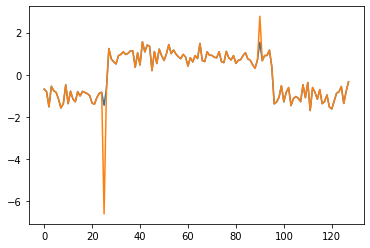

In [17]:
plt.plot(X_test[777])
plt.plot(np.array(min_edit_cf[777]))